# Setelah melakukan EDA pada tugas sebelumnya sekarang saya akan melakukan Modeling untuk Supervised Learning Regression dikarenakan Dataset mempunyai Label ('SalePrice') dan akan mengembalikan nilai Numerik pada setiap sampel.

#**MODELLING**

##Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split #pembagi dataset menjadi training dan testing set
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import skew, boxcox, norm, uniform, randint
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# pd.options.display.max_columns = None
# pd.options.display.max_rows = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Datasets/House_prices/train.csv")

In [ ]:
df_cat = df.loc[:,df.dtypes == 'object']
df_num = df.loc[:,df.dtypes != 'object']

In [ ]:
df.shape

(1460, 81)

##Setelah mengetahui Kolom Label 'SalePrice' memiliki data yang Skew, saya memutuskan untuk mengubahnya menjadi **Distribusi Normal** menggunakan Teknik Menghitung Logaritma Natural dari nilai ditambah dengan 1.

##Penambahan 1 dilakukan untuk menghindari perhitungan logaritma dari nilai 0, karena logaritma dari nol tidak terdefinisi.

In [ ]:
# log(1+x) transform
df["SalePrice"] = np.log1p(df["SalePrice"])

###Distribusi Data 'SalePrice' setelah dibentuk menjadi Distribusi normal.


 mu = 12.02 and sigma = 0.40



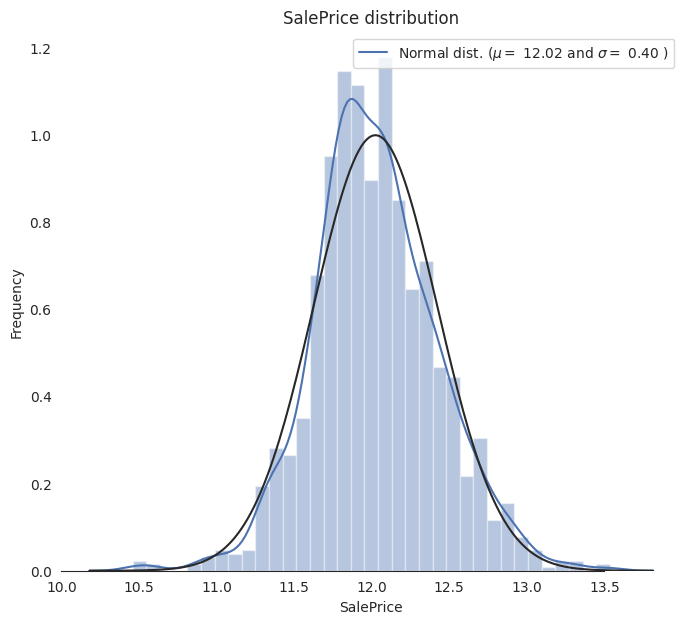

In [ ]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

#Check the new distribution
sns.distplot(df['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

##Saya melakukan Drop Kolom 'Id' karena memang tidak memiliki korelasi sama sekali dengan kenaikan harga / 'SalePrice'.

In [ ]:
df.drop(columns=['Id'], axis = 1, inplace = True)

##Setelah melakukan EDA pada tahap sebelumnya saya memutuskan untuk meng-handle Missing Value dengan cara berikut:
- Drop baris Null dari kolom 'Electrical'.
- Imputasi Null values dari data yang bersifat kategorikal dengan 'NA'.
- Imputasi Null values dari data yang bersifat Numerical dengan Median dan metodi 'bfill' untuk kolom 'GarageYrBlt'.

In [ ]:
df.dropna(subset=['Electrical'], inplace=True)

In [ ]:
for col in df_cat:
  df[col] = df[col].fillna('NA')

In [ ]:
cols_to_fill = ['LotFrontage', 'MasVnrArea']
df[cols_to_fill] = df[cols_to_fill].fillna(df[cols_to_fill].median())
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(method ='bfill')

In [ ]:
df.isna().sum().sort_values(ascending = False).head()

MSSubClass     0
MSZoning       0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
dtype: int64

In [ ]:
df.shape

(1459, 80)

##Mencari dan Menghapus Outlier menggunakan Standar Deviasi, jika standar deviasi lebih dari 3 dari rata-rata maka akan dikategorikan sebagai Outlier.

*note: coba untuk modelling tanpa remove outlier.*

In [ ]:
continuous_numerical_features = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
                                 'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageYrBlt',
                                 'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch', 'BsmtFinSF2' ,'LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal','YrSold', 'SalePrice']

In [ ]:
def find_outliers(data, threshold=3):
    mean = np.mean(data)
    std_dev = np.std(data)
    return abs(data - mean) <= threshold * std_dev

for feature in continuous_numerical_features:
    outliers = find_outliers(df[feature])
    df = df[outliers]

In [ ]:
df.shape

(1125, 80)

##Splitting Data menjadi Train dan Test

In [ ]:
train = df.drop(['SalePrice'], axis=1)
test = df['SalePrice'].reset_index(drop=True)

###Memisahkan data numeric dari train data

In [ ]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        numeric.append(i)

##Mencari data numerical yang memiliki distribusi Skew.

In [ ]:
# Find skewed numerical features
skew_features = train[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 23 numerical features with Skew > 0.5 :


3SsnPorch        31.224270
LowQualFinSF     17.221130
MiscVal           7.663671
ScreenPorch       5.102727
BsmtFinSF2        4.618611
KitchenAbvGr      4.392774
BsmtHalfBath      4.345969
EnclosedPorch     2.931997
MasVnrArea        1.611893
OpenPorchSF       1.455666
dtype: float64

##Saya menggunakan metode transformasi Box-Cox untuk menghandle skew data.


Skewness data setelah menerapkan metode transformasi Box-Cox.

In [ ]:
for feat in skew_index:
    train[feat] = boxcox(train[feat] + 1)[0]  # Tambahkan 1 untuk menghindari log(0)

skew_features_after = train[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
print("Skewness after Box-Cox transformation:")
print(skew_features_after)

Skewness after Box-Cox transformation:
3SsnPorch        23.653790
LowQualFinSF     16.680934
MiscVal           5.673229
ScreenPorch       4.694855
BsmtHalfBath      4.015363
BsmtFinSF2        3.363931
EnclosedPorch     2.378164
HalfBath          0.573782
MasVnrArea        0.448324
BsmtFullBath      0.444318
2ndFlrSF          0.302060
MoSold            0.222659
Fireplaces        0.185321
OverallQual       0.145985
LotArea           0.123533
BedroomAbvGr      0.108444
WoodDeckSF        0.101196
YrSold            0.089994
MSSubClass        0.068251
OverallCond       0.037611
TotalBsmtSF       0.025358
LotFrontage       0.021711
TotRmsAbvGrd      0.003118
OpenPorchSF      -0.000101
1stFlrSF         -0.002023
GrLivArea        -0.010429
GarageArea       -0.048864
FullBath         -0.097940
BsmtUnfSF        -0.276915
GarageCars       -0.362727
BsmtFinSF1       -0.401228
YearRemodAdd     -0.516667
YearBuilt        -0.608016
GarageYrBlt      -0.646530
KitchenAbvGr     -2.375498
PoolArea        

##Saya membuat beberapa Fitur baru yang diharapkan dapat membantu mengurangi tingkat Error Model.

In [ ]:
train['BsmtFinType1_Unf'] = 1*(train['BsmtFinType1'] == 'Unf')
train['HasWoodDeck'] = (train['WoodDeckSF'] == 0) * 1
train['HasOpenPorch'] = (train['OpenPorchSF'] == 0) * 1
train['HasEnclosedPorch'] = (train['EnclosedPorch'] == 0) * 1
train['Has3SsnPorch'] = (train['3SsnPorch'] == 0) * 1
train['HasScreenPorch'] = (train['ScreenPorch'] == 0) * 1
train['YearsSinceRemodel'] = train['YrSold'].astype(int) - train['YearRemodAdd'].astype(int)
train['Total_Home_Quality'] = train['OverallQual'] + train['OverallCond']
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
train['YrBltAndRemod'] = train['YearBuilt'] + train['YearRemodAdd']

train['Total_sqr_footage'] = (train['BsmtFinSF1'] + train['BsmtFinSF2'] +
                                 train['1stFlrSF'] + train['2ndFlrSF'])
train['Total_Bathrooms'] = (train['FullBath'] + (0.5 * train['HalfBath']) +
                               train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath']))
train['Total_porch_sf'] = (train['OpenPorchSF'] + train['3SsnPorch'] +
                              train['EnclosedPorch'] + train['ScreenPorch'] +
                              train['WoodDeckSF'])
train['TotalBsmtSF'] = train['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
train['2ndFlrSF'] = train['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
train['GarageArea'] = train['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
train['GarageCars'] = train['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
train['LotFrontage'] = train['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
train['MasVnrArea'] = train['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
train['BsmtFinSF1'] = train['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

train['haspool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['has2ndfloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['hasgarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['hasbsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['hasfireplace'] = train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

train['Total_area'] = train['GrLivArea'] + train['TotalBsmtSF'] + train['WoodDeckSF'] + train['OpenPorchSF'] + train['EnclosedPorch']+ train['3SsnPorch'] + train['ScreenPorch']
train["Number_of_floors"] = (train["TotalBsmtSF"] != 0).astype('int64') + (train["1stFlrSF"] != 0).astype('int64') + (train["2ndFlrSF"] != 0).astype('int64')
train['HasBsmt'] = train['BsmtQual'].map(lambda x: 1 if x != 'NA' else 0)
train["Has_fireplace"] = train["FireplaceQu"].map(lambda x: 1 if x != 'NA' else 0)
train['Total_Full_Bath'] = train['FullBath'] + train['BsmtFullBath']
train['Total_Half_Bath'] = train['HalfBath'] + train['BsmtHalfBath']
train["Is_Remodeled"] = (train["YearBuilt"] != train["YearRemodAdd"]).astype('int64')
train['House_Until_Sale'] = train['YrSold'] - train['YearBuilt']
train['Remodeled_Until_Sale'] = train['YrSold'] - train['YearRemodAdd']
train['Remodeled_Until_Sale'] = train['Remodeled_Until_Sale'] * train['Is_Remodeled']
train['House_Age'] = 2024 - train['YearBuilt']
train['Quality_Overall'] = train['OverallQual'] * train['OverallCond']

mendrop kolom yang saya rasa tidak diperlukan.

In [ ]:
train = train.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

##Melakukan Feature Transformation pada Data:
### Logs Function berguna untuk:
- menangani skewness dalam distribusi data.
- membantu relasi linear yang lebih baik antara variabel.

### Squares Function
- Membantu model untuk menangkap pola-pola yang lebih detail/kompleks pada data.
- membantu relasi yang tidak linear antara variabel.



In [ ]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

train = logs(train, log_features)

In [ ]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res

squared_features = ['YearRemodAdd', 'LotFrontage_log',
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
train = squares(train, squared_features)

##Mengubah kategorikal data menjadi Numerical dengan teknik One Hot Encoding.

In [ ]:
train = pd.get_dummies(train).reset_index(drop=True)
train.shape

(1125, 347)

In [ ]:
train.isna().sum().sort_values(ascending = False).head()

MSSubClass          0
ExterCond_Fa        0
Foundation_Stone    0
Foundation_Slab     0
Foundation_PConc    0
dtype: int64

##Memastikan tidak ada data yang Duplicated sebelum memasuki tahap Modelling

In [ ]:
train = train.loc[:,~train.columns.duplicated()]

In [ ]:
train.shape

(1125, 346)

##Splitting Data kedalam 4 bagian yaitu X Train, Y Train dan X Test dan Y Test, ini dilakukan agar model memiliki data untuk belajar dan memprediksi data baru.

In [ ]:
X = train
y = test

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state=1)

##Membuat data yang sudah di Normalisasi dan Standarisasi untuk melakukan experiment apakah akan berpengaruh terhadap model yang saya pilih kali ini.

In [ ]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [ ]:
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

##Pada kasus Regressi kali ini saya memilih Model:
- **Linear Regression**, ini adalah salah satu model yang paling sederhana dan memiliki waktu training yang cepat.

  Saya menggunakan ini karena adanya hubungan yang cukup baik antara variabel independent dan dependent ('SalePrice')

- **Random Forest Regressor**, saya menggunakan model ini karena dapat menghandle data yang memiliki banyak fitur seperti data saya kali ini.

- **XGBoost Regressor**, Efesien dalam menangani data yang besar dan kompleks.

  XGBoost Regressor memiliki kelebihan banyak opsi Tuning agar model kita dapat lebih baik lagi nantinya.

In [ ]:
# **Tidak Menggunakan Normalisasi atau Standarisasi**

linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

random_forest_model = RandomForestRegressor(random_state=1)
random_forest_model.fit(X_train, y_train)

xgboost_model = XGBRegressor(random_state=1)
xgboost_model.fit(X_train, y_train)

y_pred_linear = linear_reg_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)
y_pred_xgboost = xgboost_model.predict(X_test)

linear = mean_squared_error(y_test, y_pred_linear, squared=False)
rf = mean_squared_error(y_test, y_pred_rf, squared=False)
xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)

# **Menggunakan Normalisasi**

random_forest_model = RandomForestRegressor(random_state=1)
random_forest_model.fit(X_train_normalized, y_train)

xgboost_model = XGBRegressor(random_state=1)
xgboost_model.fit(X_train_normalized, y_train)

y_pred_linear = linear_reg_model.predict(X_test_normalized)
y_pred_rf = random_forest_model.predict(X_test_normalized)
y_pred_xgboost = xgboost_model.predict(X_test_normalized)

linear_normalisasi = mean_squared_error(y_test, y_pred_linear, squared=False)
rf_normalisasi = mean_squared_error(y_test, y_pred_rf, squared=False)
xgboost_normalisasi = mean_squared_error(y_test, y_pred_xgboost, squared=False)

# **Menggunakan standarisasi**

linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_standard, y_train)

random_forest_model = RandomForestRegressor(random_state=1)
random_forest_model.fit(X_train_standard, y_train)

xgboost_model = XGBRegressor(random_state=1)
xgboost_model.fit(X_train_standard, y_train)

y_pred_linear = linear_reg_model.predict(X_test_standard)
y_pred_rf = random_forest_model.predict(X_test_standard)
y_pred_xgboost = xgboost_model.predict(X_test_standard)

linear_standarisasi = mean_squared_error(y_test, y_pred_linear, squared=False)
rf_standarisasi = mean_squared_error(y_test, y_pred_rf, squared=False)
xgboost_standarisasi = mean_squared_error(y_test, y_pred_xgboost, squared=False)

Saya menggunakan RMSE karena ingin mengevaluasi kesalahan model dalam unit yang sama dengan variabel target.


In [ ]:
# Evaluasi menggunakan RMSE

print("**Tidak Menggunakan Normalisasi atau Standarisasi**")
print("Linear Regression RMSE:", linear)
print("Random Forest RMSE:", rf)
print("XGBoost RMSE:", xgboost)

print("")

print("**Menggunakan Normalisasi**")
print("Linear Regression RMSE:", linear_normalisasi)
print("Random Forest RMSE:", rf_normalisasi)
print("XGBoost RMSE:", xgboost_normalisasi)

print("")

print("**Menggunakan standarisasi**")
print("Linear Regression RMSE:", linear_standarisasi)
print("Random Forest RMSE:", rf_standarisasi)
print("XGBoost RMSE:", xgboost_standarisasi)

**Tidak Menggunakan Normalisasi atau Standarisasi**
Linear Regression RMSE: 0.12819422538049505
Random Forest RMSE: 0.1208710351162098
XGBoost RMSE: 0.12223459098564823

**Menggunakan Normalisasi**
Linear Regression RMSE: 117459.92875895723
Random Forest RMSE: 0.12064015748666915
XGBoost RMSE: 0.122376603489279

**Menggunakan standarisasi**
Linear Regression RMSE: 6060523964.616802
Random Forest RMSE: 0.12095986248547103
XGBoost RMSE: 0.12230180087907865


##Membuat Fungsi untuk melihat Learning Curves dengan metode Cross Validation dan perhitungan Error RMSE.

In [ ]:
def rmse_learning_curves(estimator, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)

    plt.figure()
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(0, 1)  # Mulai dari 0 hingga 1 pada sumbu y
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training RMSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation RMSE")

    plt.legend(loc="best")
    return plt

###Learning Curves kali ini menurut saya masih cenderung Overfitting dikarenakan data training dan CV (data validation) tidak terlalu berdekatan.
###- Training data memiliki Tingkat Error sebanyak 0 di awal dan naik sangat sedikit di akhir training.
###- Cross Validation data memiliki tingkat error sebanyak 0.19 di awal dan menurun ke angka 0.13 diakhir.
###Saya memutuskan untuk melakukan Tuning agar mendapatkan Model yang lebih baik dan optimal.

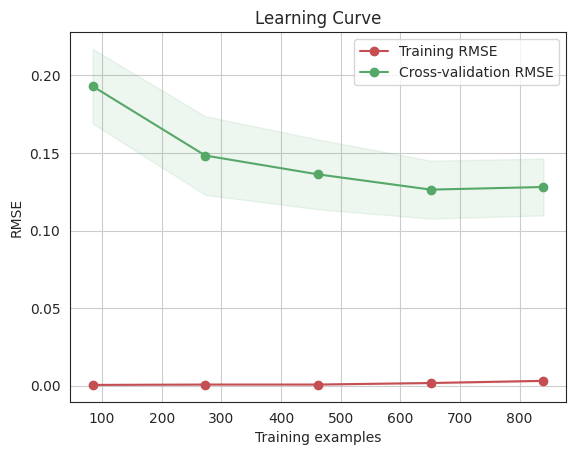

In [ ]:
estimator = XGBRegressor(random_state=42)
rmse_learning_curves(estimator, X_train, y_train, cv=15)
plt.show()

#Tuning

###Saya menggunakan Model XGBRegressor agar dapat melakukan Tuning dengan maksimal.
### Saya menggunakan teknik RandomizedSearch dengan parameter yang sudah saya buat, dengan iterasi sebanyak 50x dan Lipatan Cross Validation sebanyak 10.
### dimana akan terjadi model fitting sebanyak 500x nantinya karena pada setiap iterasi (50 iterasi) akan dilakukan Cross Validation dengan 10 lipatan.

In [ ]:
xgboost_model = XGBRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(50, 1000),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.001, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': [0, 0.1, 0.3, 1, 3, 10],
    'reg_lambda': [0, 0.1, 0.3, 1, 3, 10],
    'reg_alpha': [0, 0.1, 0.3, 1, 3, 10],
    'min_child_weight': [1, 5, 10, 20],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
}

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgboost_model, param_distributions=param_dist, n_iter=50,
                                   scoring='neg_mean_squared_error', cv=10, verbose=1, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
y_pred_best = random_search.best_estimator_.predict(X_test)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found:  {'colsample_bytree': 0.9813242073389625, 'gamma': 0, 'learning_rate': 0.20754997022960991, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 683, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1}


###Mencoba melakukan Modelling dengan Parameter XGBRegressor sesudah proses Tuning.

In [ ]:
best_params = {
    'colsample_bytree': 0.9813242073389625, 'gamma': 0, 'learning_rate': 0.20754997022960991, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 683,
    'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1
}

###Membuat Model dengan Parameter Tuning, hasilnya adalah tingkat error RMSE menurun.

In [ ]:
# Create and train an XGBoost Regressor model
xgboost_model = XGBRegressor(**best_params)
xgboost_model.fit(X_train, y_train)

# Make predictions
y_pred_xgboost = xgboost_model.predict(X_test)

# Calculate RMSE for model
xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
rmse = []
rmse.append(xgboost)

print("XGBoost RMSE:", xgboost)

XGBoost RMSE: 0.10069436161513365


##Bentuk Learning Curves kali ini lebih mendekati Good Fit pada model dan Memiliki tingkat Error lebih sedikit.

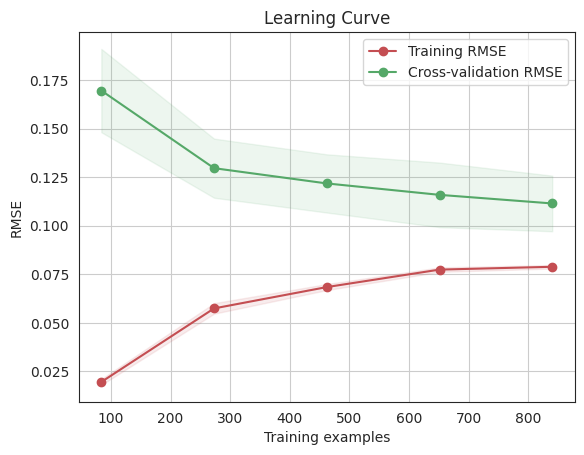

In [ ]:
rmse_learning_curves(xgboost_model, X_train, y_train, cv=15)
plt.show()

##Mencoba melihat apakah Tebakan Model mendekati dari nilai sebenarnya (y_test)

In [ ]:
xgboost_model = XGBRegressor(**best_params)
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)

In [ ]:
hasil = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

### Hasilnya menurut saya Model kali ini sudah cukup mendekati Nilai Target yang sebenarnya.

In [ ]:
hasil.head()

,Actual,Predicted
81,12.100718,12.028839
491,12.751303,12.872659
860,11.775297,11.815799
216,11.385103,11.524157
259,11.944714,12.137025


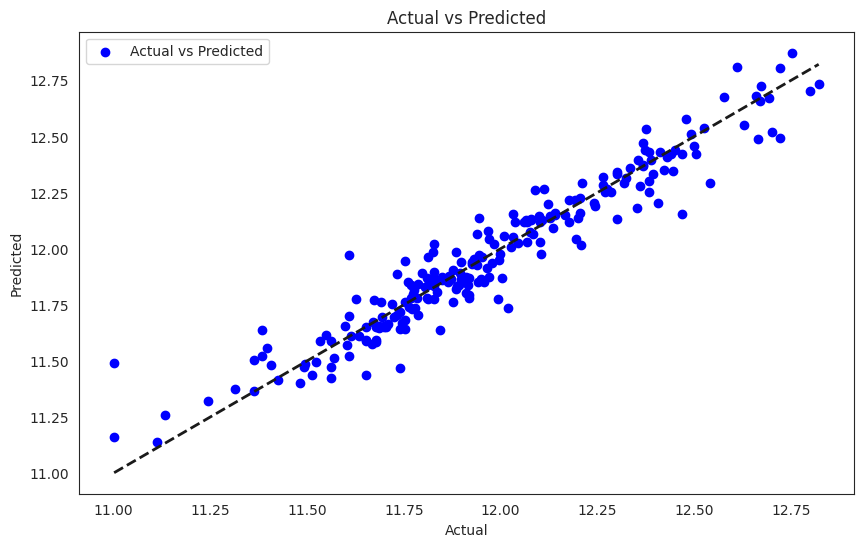

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Garis diagonal untuk perbandingan
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()